In [217]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from clean_data import clean_data
from preprocess_fit import preprocess_fit

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Load feature info
feat_info = pd.read_csv('features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

In [80]:
# Load and clean population data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
azdias_clean, azdias_dropped = clean_data(azdias, feat_info, row_threshold=10)

# Preprocess and fit population data
azdias_pca, imputer, scaler, pca = preprocess_fit(azdias_clean, pca_n=76, impute_strat='median')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
# Cluster population data and predict labels 
k = 6
kmeans = KMeans(n_clusters=k)
clust_model = kmeans.fit(azdias_pca)
population_labels = clust_model.predict(azdias_pca)

In [82]:
# impute, scale, and PCA
def preprocess_transform(df_clean, imputer, scaler, pca):
    df_inputed = imputer.transform(df_clean)
    df_scaled = scaler.transform(df_inputed) 
    df_pca = pca.transform(df_scaled)
    return df_pca

In [83]:
# Load in the customer demographics data.
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean, customers_dropped = clean_data(customers, feat_info, row_threshold=10)
customers_pca = preprocess_transform(customers_clean, imputer, scaler, pca)
customers_labels = clust_model.predict(customers_pca)

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


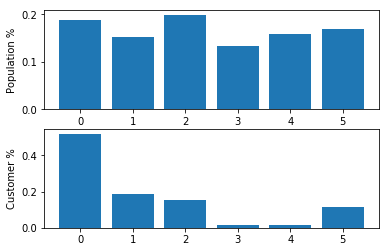

In [180]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pop = pd.Series(population_labels)
cust = pd.Series(customers_labels)

plt.subplot(2, 1, 1)
ax1 = plt.bar(pop.value_counts().index, pop.value_counts() / pop.value_counts().sum())
plt.ylabel('Population %')

plt.subplot(2, 1, 2)
ax2 = plt.bar(cust.value_counts().index, cust.value_counts() / cust.value_counts().sum())
plt.ylabel('Customer %')

plt.show()

## Part 2: Supervised Learning Model

In [181]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [182]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [194]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

X_clean, X_dropped = clean_data(X, feat_info, row_threshold=len(mailout_train.columns))
X_pca = preprocess_transform(X_clean, imputer, scaler, pca)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [196]:
y_train.value_counts()

0    33943
1      426
Name: RESPONSE, dtype: int64

### Try applying clustering

In [197]:
X_train_labels = clust_model.predict(X_train_pca)

In [206]:
print(X_train.shape)
print(len(X_train_labels))
X_combined = pd.DataFrame({'RESPONSE':y_train, 'Cluster':X_train_labels})
X_combined.head()

(34369, 76)
34369


,RESPONSE,Cluster
25923,0,0
14938,0,1
1928,0,0
20513,0,2
2325,0,0


In [208]:
p_yes = X_combined[X_combined.RESPONSE == 1].Cluster.value_counts() / X_combined[X_combined.RESPONSE == 1].Cluster.value_counts().sum()
print(p_yes)
p_no = X_combined[X_combined.RESPONSE == 0].Cluster.value_counts() / X_combined[X_combined.RESPONSE == 0].Cluster.value_counts().sum()
print(p_no)

0    0.415493
2    0.187793
4    0.161972
5    0.119718
1    0.107981
3    0.007042
Name: Cluster, dtype: float64
0    0.362107
2    0.210647
4    0.174911
1    0.136346
5    0.105500
3    0.010488
Name: Cluster, dtype: float64


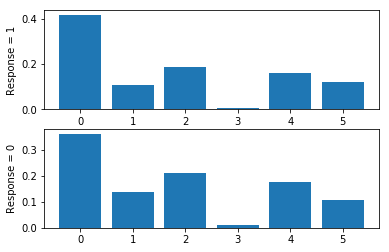

In [209]:
plt.subplot(2, 1, 1)
ax1 = plt.bar(p_yes.index, p_yes)
plt.ylabel('Response = 1')

plt.subplot(2, 1, 2)
ax1 = plt.bar(p_no.index, p_no)
plt.ylabel('Response = 0')

plt.show()

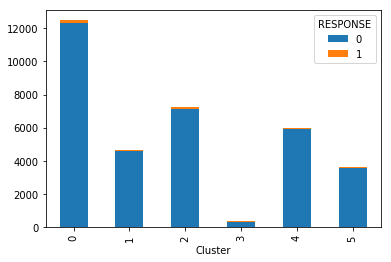

In [210]:
counts = X_combined.groupby('RESPONSE').Cluster.value_counts().unstack(0)
counts.plot.bar(stacked=True)

### AdaBoost

In [222]:
ada = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'), algorithm='SAMME.R')
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [224]:
y_preds = ada.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8487
           1       0.02      0.08      0.03       106

   micro avg       0.95      0.95      0.95      8593
   macro avg       0.50      0.52      0.50      8593
weighted avg       0.98      0.95      0.96      8593

